# Gaussian Mixture Model

Original NB by Abe Flaxman, modified by Thomas Wiecki


In [1]:
!date
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

Fri Nov 18 18:11:28 CST 2016


In [2]:
import pymc3 as pm, theano.tensor as tt

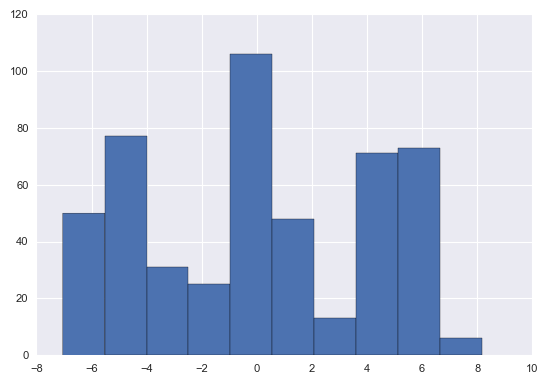

In [3]:
# simulate data from a known mixture distribution
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [4]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))
    
    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

INFO (theano.gof.compilelock): Waiting for existing lock by process '4344' (I am process '4379')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/fonnescj/.theano/compiledir_Darwin-16.1.0-x86_64-i386-64bit-i386-3.5.2-64/lock_dir


In [5]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    tr = pm.sample(10000, step=[step1, step2])

/Users/fonnescj/anaconda3/envs/dev/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
100%|██████████| 10000/10000 [02:00<00:00, 82.75it/s]


## Full trace

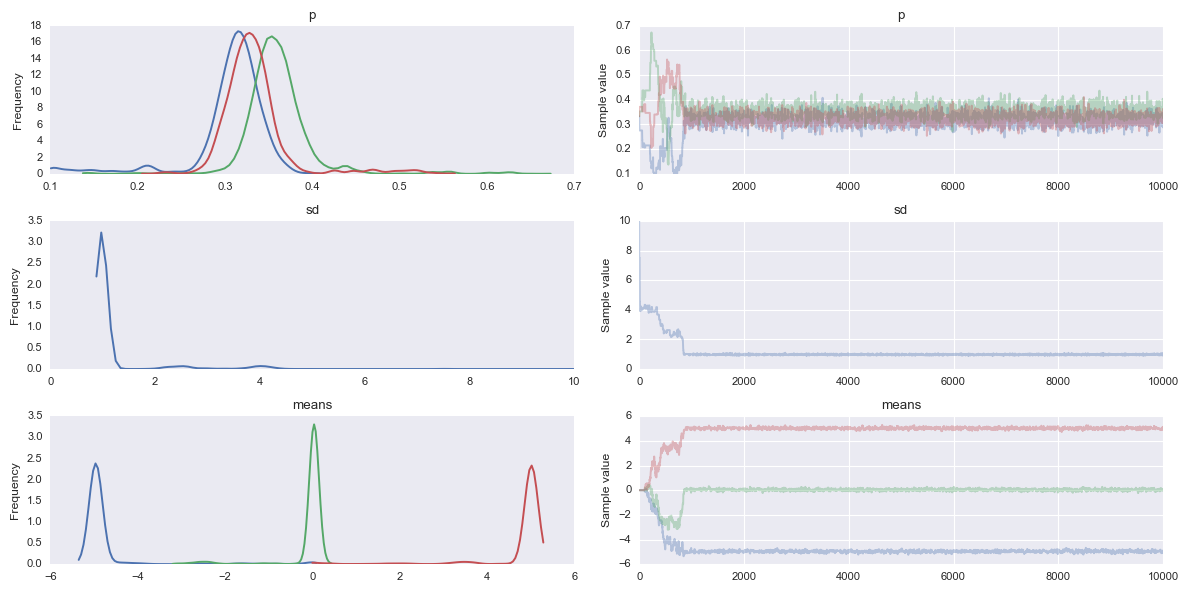

In [6]:
pm.plots.traceplot(tr, ['p', 'sd', 'means']);

## After convergence

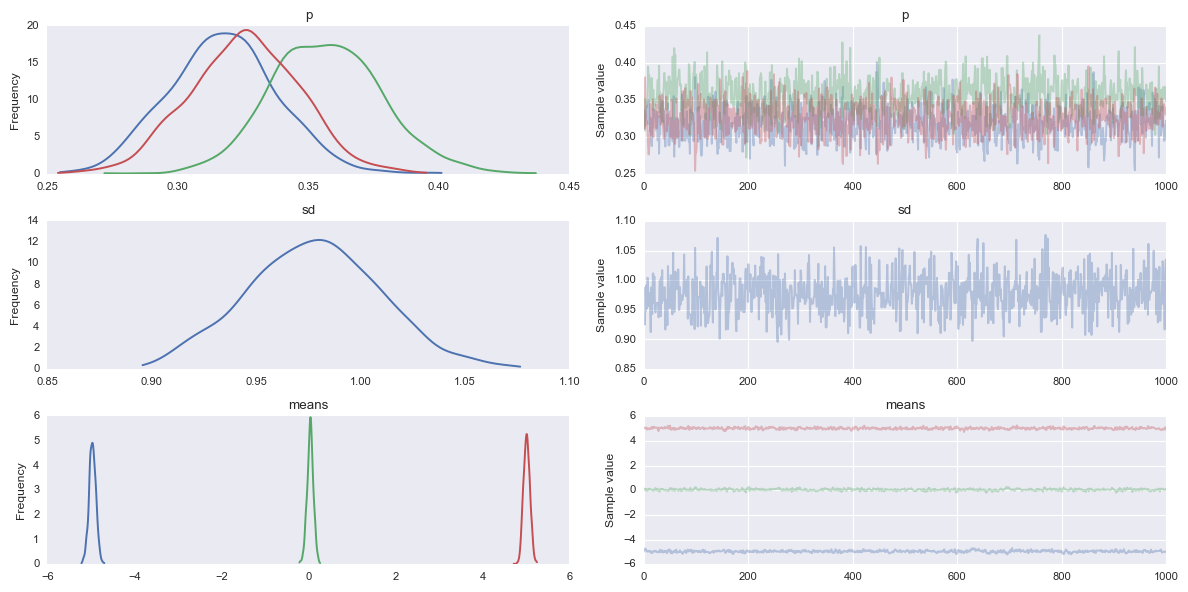

In [7]:
# take a look at traceplot for some model parameters
# (with some burn-in and thinning)
pm.plots.traceplot(tr[5000::5], ['p', 'sd', 'means']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1162b0860>]], dtype=object)

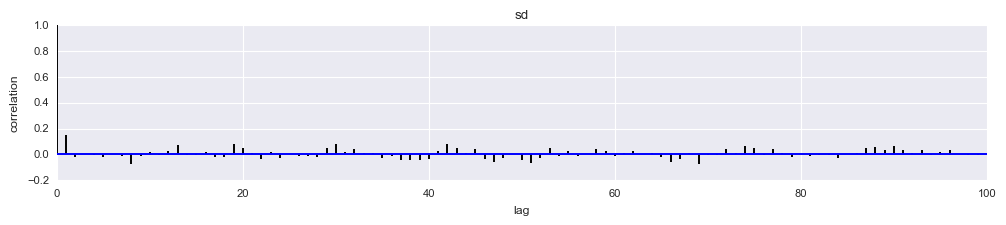

In [8]:
# I prefer autocorrelation plots for serious confirmation of MCMC convergence
pm.autocorrplot(tr[5000::5], varnames=['sd'])

## Sampling of cluster for individual data point

(0.0, 1000.0, -0.1, 2.1)

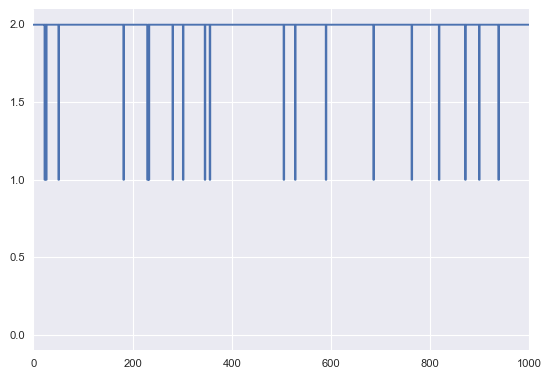

In [9]:
i=0
plt.plot(tr['category'][5000::5, i], drawstyle='steps-mid')
plt.axis(ymin=-.1, ymax=2.1)

true cluster: 2
  data value: 3.29


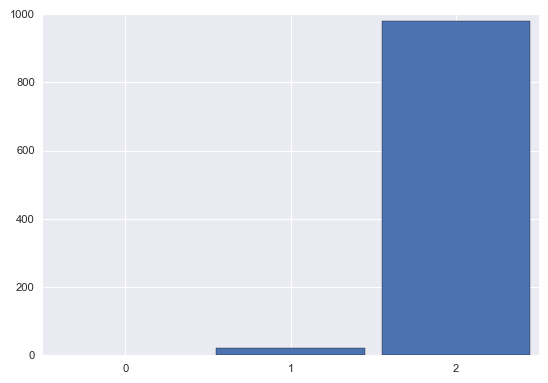

In [10]:
def cluster_posterior(i=0):
    print('true cluster:', v[i])
    print('  data value:', np.round(data[i],2))
    plt.hist(tr['category'][5000::5,i], bins=[-.5,.5,1.5,2.5,], rwidth=.9)
    plt.axis(xmin=-.5, xmax=2.5)
    plt.xticks([0,1,2])
cluster_posterior(i)